<h2 align="center">Codebasics DL Course: Batch Normalization</h2>

Batch normalization research paper: https://arxiv.org/pdf/1502.03167

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# Load and normalize the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)


train_subset = Subset(full_train_dataset, torch.arange(5000))
test_subset = Subset(full_test_dataset, torch.arange(1000))

train_loader = DataLoader(train_subset, batch_size=60, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=60, shuffle=True)

### Train a Neural Net Without Batch Normalization

In [73]:
# Define the model
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),  
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [74]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training 
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()          # Zero the gradients
            outputs = model(images)        # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                # Backpropagate
            optimizer.step()               # Update weights
            
            if batch%100 == 0:
                print(f"Epoch {epoch}, Batch: {batch}, Train Loss: {loss.item():0.2f}")
            
        
        # Evaluation
        model.eval()
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
    return val_accuracies

In [87]:
# Instantiate the model, define loss function and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_accuracies_no_bn = train_model(model, train_loader, test_loader, optimizer, criterion, 10)

Epoch 0, Batch: 0, Train Loss: 2.32
Epoch 1, Batch: 0, Train Loss: 0.46
Epoch 2, Batch: 0, Train Loss: 0.32
Epoch 3, Batch: 0, Train Loss: 0.29
Epoch 4, Batch: 0, Train Loss: 0.16
Epoch 5, Batch: 0, Train Loss: 0.27
Epoch 6, Batch: 0, Train Loss: 0.22
Epoch 7, Batch: 0, Train Loss: 0.20
Epoch 8, Batch: 0, Train Loss: 0.19
Epoch 9, Batch: 0, Train Loss: 0.28


In [88]:
print(val_accuracies_no_bn)

[0.844, 0.862, 0.881, 0.886, 0.874, 0.896, 0.898, 0.897, 0.897, 0.897]


### With Batch Normalization

In [93]:
# Define the model
class MNISTClassifierWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [98]:
# Instantiate the model, define loss function and optimizer
model_with_bn = MNISTClassifierWithBN().to(device)
criterion_with_bn = nn.CrossEntropyLoss()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)

val_accuracies_with_bn = train_model(model_with_bn, train_loader, test_loader, optimizer_with_bn, criterion_with_bn, 10)

Epoch 0, Batch: 0, Train Loss: 2.41
Epoch 1, Batch: 0, Train Loss: 0.42
Epoch 2, Batch: 0, Train Loss: 0.15
Epoch 3, Batch: 0, Train Loss: 0.20
Epoch 4, Batch: 0, Train Loss: 0.13
Epoch 5, Batch: 0, Train Loss: 0.04
Epoch 6, Batch: 0, Train Loss: 0.01
Epoch 7, Batch: 0, Train Loss: 0.02
Epoch 8, Batch: 0, Train Loss: 0.01
Epoch 9, Batch: 0, Train Loss: 0.02


In [99]:
val_accuracies_with_bn

[0.879, 0.918, 0.929, 0.924, 0.926, 0.927, 0.937, 0.929, 0.941, 0.931]

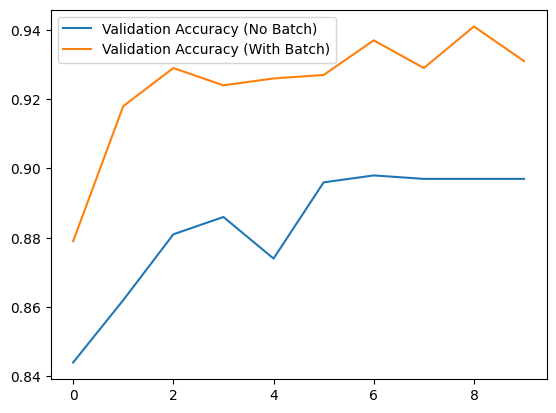

In [100]:
plt.plot(val_accuracies_no_bn, label="Validation Accuracy (No Batch)")
plt.plot(val_accuracies_with_bn, label="Validation Accuracy (With Batch)")
plt.legend()
plt.show()